# Detection of COVID-19 from X-rays 

## Importing Libraries

In [2]:
!pip install plotly==4.14.1

     |████████████████████████████████| 13.2MB 247kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [6]:

import os
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


#Computational vision 
import cv2 

#Machine Learning
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


## Loading the files

In [3]:
from google.colab import drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
files_path = '/content/drive/MyDrive/Data-Projects/Covid-Xrays/Dataset'

In [10]:
os.listdir(files_path)

['.DS_Store', '2', '3', '1', '0']

## Preparing the data for the study

Changing the scale of the images:

In [11]:
image_generator = ImageDataGenerator(rescale=1./255)

#### Training data:
Creating a training data geratator (indicated by 'subset = training'), with batch size of 40, from the directory of images. Target size is related to the nn structure to be implemented. It gives us the size of the images. The parameter class_mode is categorical because this is a classification model. 

In summary, train_generator variable reads the images in batches of 40 images. 

In [12]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=files_path, shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


*It detected 532 images belonging to 4 classes. Since the algorithm reads the images in batches of 40, we have 13 batches of images (532/40)*

In [13]:
train_images, train_labels = next(train_generator)

In [14]:
train_images.shape

(40, 256, 256, 3)

In [15]:
train_labels

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

According to the instructions in the dataset, the images are classified as follows:
* 0 - Covid-19
* 1 - Normal X-ray
* 2 - Viral Pneumonia X-ray
* 3 - Bacterial Pneumonia X-ray

In [16]:
labels_names = {0: 'COVID-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

## Visualizing the data

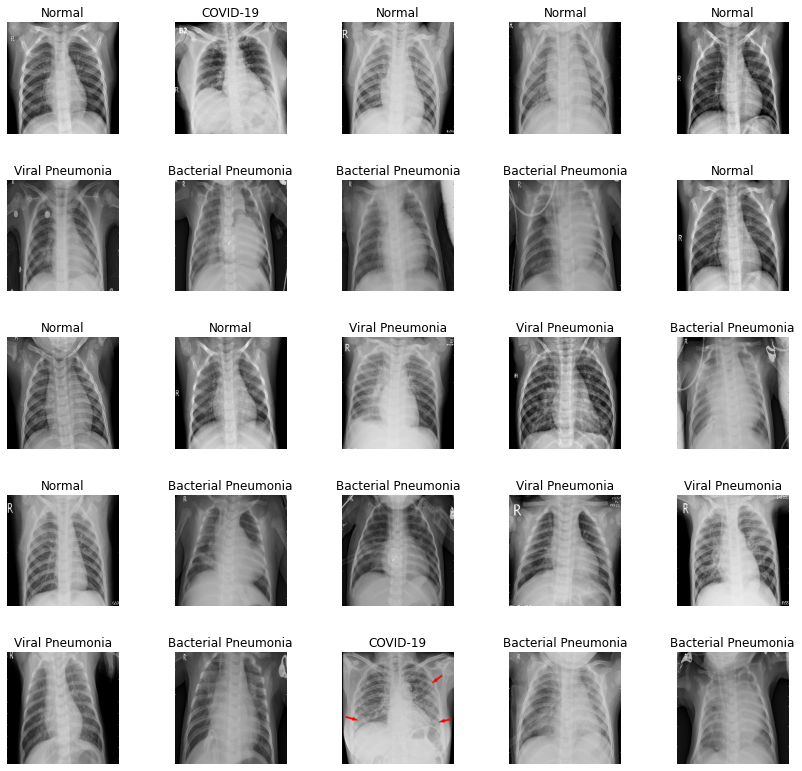

In [18]:
fig, axes = plt.subplots(5, 5, figsize=(14, 14))

# .ravel() - Returning a contiguous flattened array
axes = axes.ravel()

for i in np.arange(0, 25):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])

  #Taking off the x-y axis numbers to depollute the image
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Building the Deep Learning Model

#### Building Base Model using ResNet

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 0s 0us/step


In [20]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

How many layers does the model have? 

In [21]:
len(base_model.layers)

175

In [22]:
# For the last 10 layers ( starting from conv5_block3_1_conv (Conv2D) )
for layer in base_model.layers[:-10]:
  layers.trainable = False

#### Buiding output model

In [23]:
head_model = base_model.output

#Adding AveragePoooling2D layer after base_model
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
#Building dense layers:
head_model = Dense(256, activation = 'relu')(head_model)

#20% of the neurons of dense layers will be dropped out in each epoch (zeroed) to avoid overfitting the model
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)

#Softmax to generate a distribution of probabilities for the 4 possible classes 
head_model = Dense(4, activation = 'softmax')(head_model)

#### Implementing the model


In [24]:
model = Model(inputs = base_model.input, outputs = head_model)

Compiling the model using categorical crossentropy to compute the losses and RMSprop as optimizer

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

Saving the results in a variable:

In [26]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

#### Redefining train generator for training
Reducing batch size now to 4 (it was 40 before)

In [27]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=files_path,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [28]:
#Training history
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
133/133 [==============================] - 156s 1s/step - loss: 1.3737 - accuracy: 0.5771
Epoch 2/25
133/133 [==============================] - 14s 106ms/step - loss: 0.4021 - accuracy: 0.8858
Epoch 3/25
133/133 [==============================] - 14s 106ms/step - loss: 0.2709 - accuracy: 0.9494
Epoch 4/25
133/133 [==============================] - 14s 105ms/step - loss: 0.1311 - accuracy: 0.9527
Epoch 5/25
133/133 [==============================] - 14s 106ms/step - loss: 0.1923 - accuracy: 0.9510
Epoch 6/25
133/133 [==============================] - 14s 106ms/step - loss: 0.2892 - accuracy: 0.9458
Epoch 7/25
133/133 [==============================] - 14s 107ms/step - loss: 0.2252 - accuracy: 0.9665
Epoch 8/25
133/133 [==============================] - 14s 107ms/step - loss: 0.0907 - accuracy: 0.9822
Epoch 9/25
133/133 [==============================] - 14s 107ms/step - loss: 0.0376 - accuracy: 0.9936
Epoch 10/25
133/133 [==============================] - 14s 107ms/step - los

## Evaluating the Results

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

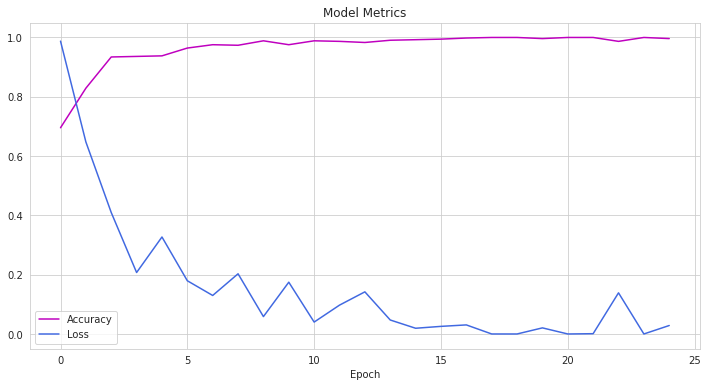

In [30]:
plt.figure(figsize = (12,6))
sns.set_style("whitegrid") 
plt.plot(history.history['accuracy'], color='m')
plt.plot(history.history['loss'], color='royalblue')
plt.title('Model Metrics')
plt.xlabel('Epoch')
#plt.ylabel('Taxa de acerto e erro')
plt.legend(['Accuracy', 'Loss']);

In [31]:
test_directory = '/content/drive/MyDrive/Data-Projects/Covid-Xrays/Test'
os.listdir(test_directory)

['3', '2', '0', '1']

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [33]:
evaluate = model.evaluate_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



In [34]:
evaluate

[3.7245593070983887, 0.75]

In [35]:
len(os.listdir(test_directory))

4

In [36]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [37]:
#Printing the predictions
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 3, 2, 0, 1, 3, 0, 0, 3, 3, 2, 3, 1]


In [38]:
#Original classifications for the images
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


#### Getting the accuracy score for the predictions and visualizing a sample of the results

In [39]:
accuracy_score(original, prediction)

0.725

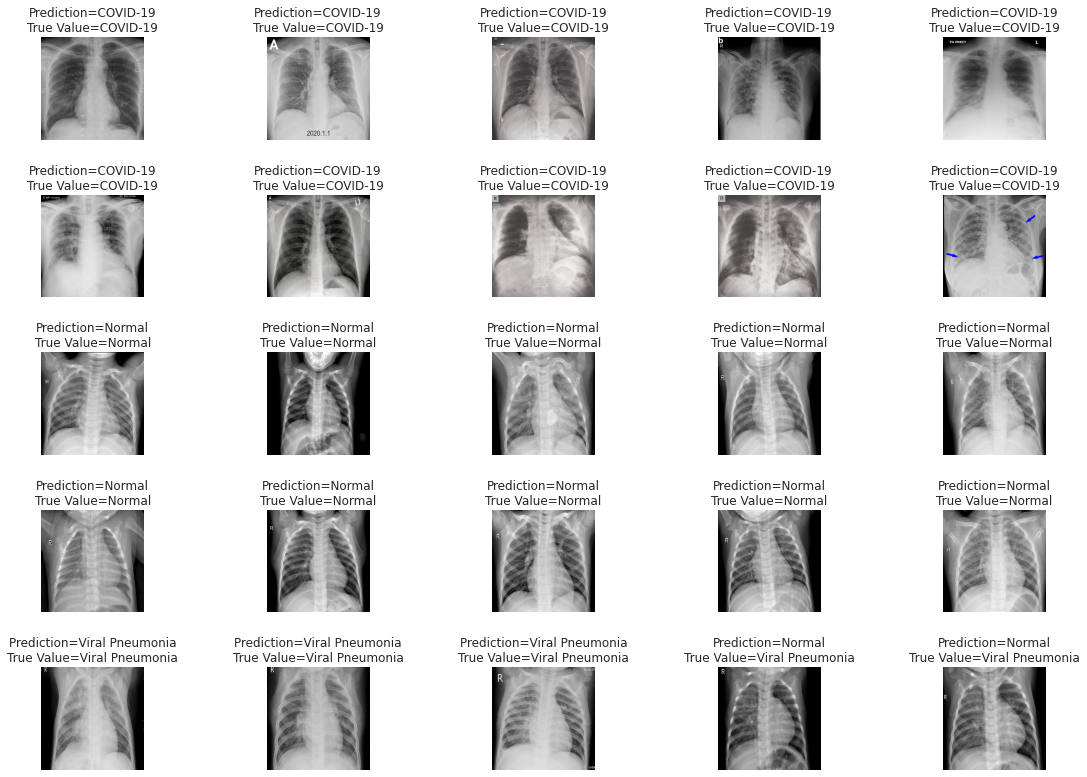

In [40]:
fig, axes = plt.subplots(5, 5, figsize=(18,14))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Prediction={}\nTrue Value={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [41]:
labels_names

{0: 'COVID-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

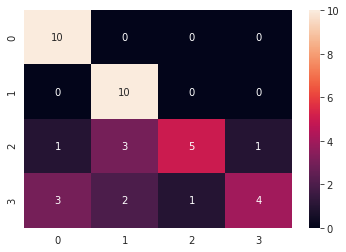

In [42]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [43]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.67      1.00      0.80        10
           2       0.83      0.50      0.62        10
           3       0.80      0.40      0.53        10

    accuracy                           0.73        40
   macro avg       0.75      0.72      0.70        40
weighted avg       0.75      0.72      0.70        40



#### Recall:
* 100% of COVID patients were correctly estimated as having covid-19 (recall = 1)


#### Precision: 
* 100% precision in the detection of COVID-19 patients

## Classification of One Image

Simulating the test of one image, as in a real time situation. 

In [44]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [45]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [46]:
img = cv2.imread('/content/drive/MyDrive/Data-Projects/Covid-Xrays/Test/0/nCoV-radiol.2020200269.fig1-day7.jpeg')

In [47]:
img, img.shape

(array([[[ 15,  15,  15],
         [ 24,  24,  24],
         [ 27,  27,  27],
         ...,
         [ 23,  23,  23],
         [ 21,  21,  21],
         [ 19,  19,  19]],
 
        [[  5,   5,   5],
         [ 10,  10,  10],
         [ 12,  12,  12],
         ...,
         [  7,   7,   7],
         [  5,   5,   5],
         [  3,   3,   3]],
 
        [[  8,   8,   8],
         [ 10,  10,  10],
         [ 10,  10,  10],
         ...,
         [  4,   4,   4],
         [  3,   3,   3],
         [  1,   1,   1]],
 
        ...,
 
        [[ 17,  17,  17],
         [ 30,  30,  30],
         [ 45,  45,  45],
         ...,
         [100, 100, 100],
         [102, 102, 102],
         [105, 105, 105]],
 
        [[ 14,  14,  14],
         [ 25,  25,  25],
         [ 39,  39,  39],
         ...,
         [101, 101, 101],
         [103, 103, 103],
         [107, 107, 107]],
 
        [[ 13,  13,  13],
         [ 22,  22,  22],
         [ 35,  35,  35],
         ...,
         [105, 105, 105],
  

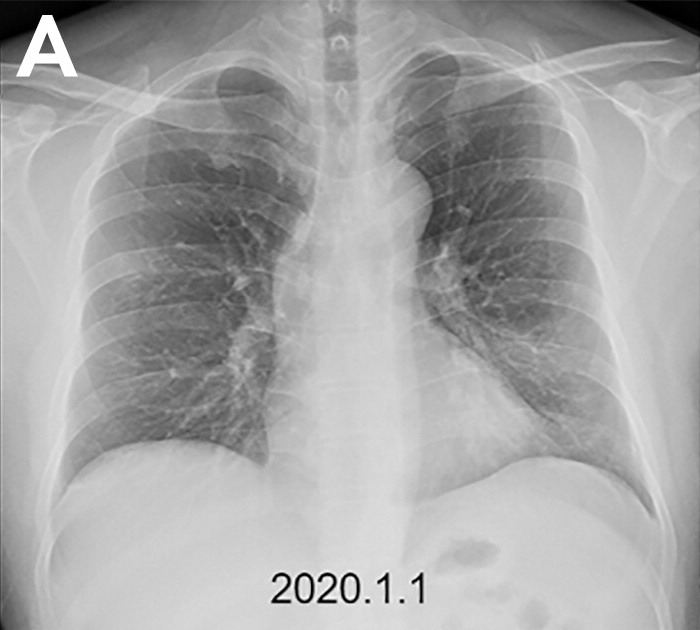

In [48]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

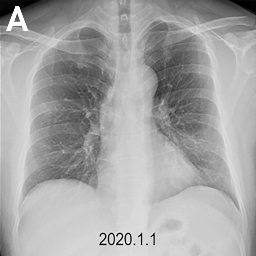

In [49]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

Normalizing the image

In [50]:
img = img / 255
img

array([[[0.05098039, 0.05098039, 0.05098039],
        [0.04705882, 0.04705882, 0.04705882],
        [0.05882353, 0.05882353, 0.05882353],
        ...,
        [0.04313725, 0.04313725, 0.04313725],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03529412, 0.03529412, 0.03529412]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03137255, 0.03137255, 0.03137255],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627]],

       ...,

       [[0.18823529, 0.18823529, 0.18823529],
        [0.29019608, 0.29019608, 0.29019608],
        [0.3372549 , 0

In [51]:
img.shape

(256, 256, 3)

In [52]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [53]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.00000e+00, 0.00000e+00, 0.00000e+00, 3.42295e-38]],
      dtype=float32)>

In [54]:
predict2 = np.argmax(predict)
predict2

0

In [55]:
labels_names[predict2], predict[0][predict2]

('COVID-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)